Imports:  

    jaxley batch for simulation  

    network batch for creating SWC tree  

        navis for writing SWC file  

    scipy for KDtree  

    cavevlient and flywire for API  


In [1]:
import numpy as np
import pandas as pd
from io import StringIO
from scipy.spatial import cKDTree # create KDTree
import matplotlib.pyplot as plt

import fafbseg # API
from fafbseg import flywire
import caveclient

import networkx as nx # create tree based on SWC
import navis

import jax
import jaxley as jx
import jax.numpy as jnp # numpy in jax
from jaxley.channels import Na, K, Leak # Mechanism

from jax import config # Device
config.update("jax_platform_name", "cpu")
config.update("jax_enable_x64", True)
#print(jax.devices())


from jax import jit, vmap, value_and_grad # Simulation and optimization
import optax
import tensorflow as tf
from tensorflow.data import Dataset

Helper functions

In [2]:
def bfs_relabel(skel):
    """
    Performs a breadth-first relabeling on a list of nodes with parent indices.
    :param node_list: A list of nodes, where each node is a tuple of the node index and its parent index.
    :return: A list of node indices visited during the search.
    """
    relabel = {}
    visited = []
    queue = [1]
    counter = 1 
    while queue:
        node_index = queue.pop(0)
        if node_index not in visited:
            visited.append(node_index)
            neighbors = list(skel.predecessors(node_index))
            queue.extend(neighbors)
            relabel[node_index] = counter
            counter += 1
    return relabel

def relabel_skeleton_swc(skel_graph, skel_df, row_name="rowId", link_name="link"):
    relabel_dict = bfs_relabel(skel_graph)
    relabel_dict[-1] = -1
    skel_df[row_name] = skel_df[row_name].map(relabel_dict)
    skel_df[link_name] = skel_df[link_name].map(relabel_dict)
    swc = "# rowId type x y z radius link\n"
    for i in range(skel_df.shape[0]):
        s = f"{int(skel_df.iloc[i][row_name])} 0 {skel_df.iloc[i].x} {skel_df.iloc[i].y} {skel_df.iloc[i].z} {skel_df.iloc[i].radius} {int(skel_df.iloc[i][link_name])}\n"
        swc += s
    return swc, relabel_dict

Load SWC file, define id, name, file name

    Currently using direct download, but there is an API to get skeleton and write into SWC file


In [3]:
# Skeleton to SWC file
root_id = 720575940622997453
neuron_name = 'MBON-18'
sk = flywire.get_skeletons(root_id)
file_name = neuron_name + '_Auto.swc'
navis.write_swc(sk, file_name)
print (sk)
# Now using downloaded SWC file:
file_name = '720575940622997453.swc'

type                                             navis.TreeNeuron
name                                                     skeleton
id                                             720575940622997453
n_nodes                                                     12191
n_connectors                                                 None
n_branches                                                   2247
n_leafs                                                      2426
cable_length                                            6441608.0
soma            [748, 1623, 1844, 1918, 1943, 1947, 1959, 1961...
units                                                 1 nanometer
dtype: object


SWC file healing and soma replacement

In [4]:
# SWC file healing
mbon_skel = pd.read_csv(file_name, comment='#', delim_whitespace=True, header=None, names=['n', 'type', 'x', 'y', 'z', 'radius', 'parent'])
mbon_skel_edges = mbon_skel[mbon_skel['parent'] != -1].copy() # Create a copy of mbon_skel and remove the root node
mbon_skel_edges['parent'] = mbon_skel_edges['parent'].astype(int) # Convert the parent column to integer type
mbon_graph = nx.from_pandas_edgelist(mbon_skel_edges, 'n', 'parent', create_using=nx.DiGraph) # Create a networkx graph from mbon_skel_edges
mbon_swc, relabel_dict = relabel_skeleton_swc(mbon_graph, mbon_skel, row_name="n", link_name="parent")
mbon_swc_df = pd.read_csv(StringIO(mbon_swc), comment='#', delim_whitespace=True, header=None, names=['n', 'type', 'x', 'y', 'z', 'radius', 'parent'])
mbon_swc_df[['x', 'y', 'z', 'radius']] = mbon_swc_df[['x', 'y', 'z', 'radius']] / 1000 # everything in um
mbon_swc_df

,n,type,x,y,z,radius,parent
0,1,0,696.27394,159.50690,187.626300,3.294,-1
1,36,0,697.92525,158.85800,182.503780,0.095,28
2,3668,0,630.10800,128.52621,107.568330,0.274,3658
3,8724,0,590.61625,122.55224,74.468125,0.160,8655
4,27625,0,540.50110,101.24493,75.562080,0.235,27621
...,...,...,...,...,...,...,...
31845,28415,0,713.58930,137.54330,148.183440,0.454,28410
31846,28420,0,713.71544,137.49962,148.134250,0.395,28415
31847,28425,0,714.03544,137.25419,148.053270,0.402,28420
31848,28430,0,714.11690,137.14366,147.999470,0.301,28425


Load soma parameters

In [5]:
soma = flywire.get_somas(root_id)
# Parameters
# Neuron diameter in drosophila is ~2um or ~2k nm
# All converted to um
volume = soma['volume'][0] #um
soma_pt = np.array((soma['pt_position'][0])/1000) #um
rad_est = (soma['rad_est'][0])/1000 #um
rad_arti = round(((3*volume)/(4*np.pi))**(1/3), 2) #um

Using materialization version 783.


In [6]:
# Soma replacement
in_bool = []
for i in range(mbon_swc_df.shape[0]):
    [x_seg, y_seg, z_seg] = np.array([mbon_swc_df.x.iloc[i], mbon_swc_df.y.iloc[i], mbon_swc_df.z.iloc[i]])
    seg_pt = np.array([x_seg, y_seg, z_seg])
    dist = np.linalg.norm(seg_pt - soma_pt)
    in_bool.append(dist <= rad_est + mbon_swc_df.radius.iloc[i]/1000) # T means in and removed
in_bool = np.array(in_bool)    
mbon_swc_df[in_bool]

mbon_swc_soma_df = mbon_swc_df[~in_bool].copy()
mbon_swc_soma_df['parent'].replace(mbon_swc_df[in_bool]['n'].tolist(), 1, inplace=True)
soma_row = pd.DataFrame({"n": [1], "type": [0], "x": [soma_pt[0]], "y": [soma_pt[1]], "z": [soma_pt[2]], "radius": [rad_arti], "parent": [-1]})
mbon_swc_soma_df = pd.concat([soma_row, mbon_swc_soma_df]).reset_index(drop=True)

rm_list = mbon_swc_df[in_bool]['n'].tolist()
rm_list

[1, 14, 13, 16, 15, 8, 9, 12, 10, 11, 6, 7, 2, 17, 5, 3, 4]

In [7]:
sorted_df = mbon_swc_soma_df.sort_values(by=['n']).reset_index(drop=True)
n_to_index = pd.Series(sorted_df.index + 1, index=sorted_df['n']).to_dict()
n_to_index[-1] = -1
sorted_df['n'] = sorted_df.index + 1
sorted_df['parent'] = sorted_df['parent'].map(n_to_index)
sorted_df

,n,type,x,y,z,radius,parent
0,1,0,696.92800,159.87200,187.48000,2.310,-1
1,2,0,698.03760,159.13047,183.36072,0.225,1
2,3,0,692.10500,159.32245,185.70836,1.406,1
3,4,0,698.05575,159.03261,183.28802,0.226,2
4,5,0,691.67310,159.33827,185.77395,1.212,3
...,...,...,...,...,...,...,...
31829,31830,0,341.66510,125.44829,186.61916,0.187,31828
31830,31831,0,341.63880,125.60413,186.68075,0.194,31830
31831,31832,0,341.63540,125.76220,186.73816,0.214,31831
31832,31833,0,341.70344,125.90131,186.76519,0.193,31832


In [8]:
# Write df into SWC file
def write_swc(df, filename):
    # df[['x', 'y', 'z', 'radius']] = df[['x', 'y', 'z', 'radius']] / 10
    df.loc[df['radius'] < 0.001, 'radius'] = 0.01
    print (df['radius'].abs().min())
    # Write to the SWC file, space-separated
    df.to_csv(filename, sep=' ', header=False, index=False)
fileName = neuron_name + '_Final.swc'
write_swc(sorted_df, fileName)

0.01


Synapse assignment

In [9]:
datastack_name = "flywire_fafb_public"
client = caveclient.CAVEclient(datastack_name)

In [10]:
class_annos_df = client.materialize.query_table("hierarchical_neuron_annotations", filter_equal_dict={"classification_system": "cell_class", "cell_type": "Kenyon_Cell"})
class_annos_df

,id,created,valid,target_id,classification_system,cell_type,id_ref,created_ref,valid_ref,pt_supervoxel_id,pt_root_id,pt_position
0,641830,2023-06-19 23:33:25.652976+00:00,t,32425,cell_class,Kenyon_Cell,32425,2023-06-19 06:44:57.877806+00:00,t,81911349130846298,720575940625290003,"[655290, 153943, 192032]"
1,644178,2023-06-19 23:33:35.978000+00:00,t,423,cell_class,Kenyon_Cell,423,2023-06-19 06:43:33.010270+00:00,t,81208073536435994,720575940608655918,"[615063, 175235, 56178]"
2,644179,2023-06-19 23:33:35.978780+00:00,t,427,cell_class,Kenyon_Cell,427,2023-06-19 06:43:33.013572+00:00,t,81067404834280837,720575940625560189,"[608580, 179448, 65433]"
3,644180,2023-06-19 23:33:35.979485+00:00,t,432,cell_class,Kenyon_Cell,432,2023-06-19 06:43:33.018022+00:00,t,81559986312359168,720575940621073840,"[635171, 178792, 160245]"
4,644181,2023-06-19 23:33:35.980246+00:00,t,437,cell_class,Kenyon_Cell,437,2023-06-19 06:43:33.022022+00:00,t,81207730341448122,720575940626075079,"[617739, 157152, 172026]"
...,...,...,...,...,...,...,...,...,...,...,...,...
5172,640467,2023-06-19 23:33:24.428909+00:00,t,37065,cell_class,Kenyon_Cell,37065,2023-06-19 06:45:10.503592+00:00,t,77759387066107730,720575940633596826,"[414016, 140075, 197155]"
5173,640476,2023-06-19 23:33:24.434935+00:00,t,37066,cell_class,Kenyon_Cell,37066,2023-06-19 06:45:10.504435+00:00,t,77900124554583464,720575940606123698,"[424746, 138498, 201204]"
5174,640475,2023-06-19 23:33:24.434267+00:00,t,37067,cell_class,Kenyon_Cell,37067,2023-06-19 06:45:10.505249+00:00,t,78181942725512202,720575940616028390,"[441897, 162042, 62684]"
5175,640499,2023-06-19 23:33:24.453956+00:00,t,37068,cell_class,Kenyon_Cell,37068,2023-06-19 06:45:10.506089+00:00,t,77759318346580287,720575940637784548,"[413596, 135776, 195048]"


In [11]:
postsyn_df = client.materialize.query_view("valid_synapses_nt_np_v6", filter_in_dict={"post_pt_root_id": [root_id]})
postsyn_df

,id,pre_pt_root_id,post_pt_root_id,connection_score,cleft_score,gaba,ach,glut,oct,ser,da,valid_nt,pre_pt_supervoxel_id,post_pt_supervoxel_id,neuropil,pre_pt_position,post_pt_position
0,918285,720575940627097361,720575940622997453,690.144470,165,0.027637,0.260075,0.087501,4.778929e-04,4.023777e-02,5.840713e-01,t,81137017664501663,81137017664501456,MB_VL_R,"[613320, 137640, 74880]","[613292, 137532, 74880]"
1,553972,720575940629022875,720575940622997453,432.047668,155,0.063886,0.413269,0.068484,3.381951e-04,8.618969e-02,3.678338e-01,t,80995936578744239,80995936578743127,MB_VL_R,"[605288, 117108, 74120]","[605404, 117100, 74040]"
2,918473,720575940625570334,720575940622997453,757.010742,163,0.053902,0.400003,0.121363,3.617471e-03,3.865422e-02,3.824601e-01,t,80996348895647212,80996348895657103,MB_VL_R,"[604932, 137884, 75280]","[604804, 137812, 75280]"
3,38915,720575940614899851,720575940622997453,864.926208,168,0.004994,0.002189,0.051190,2.270994e-04,3.717019e-02,9.042292e-01,t,81066442761913372,81066442761906832,MB_VL_R,"[608284, 125128, 75160]","[608216, 125180, 75120]"
4,460455,720575940620211622,720575940622997453,495.862915,164,0.013234,0.195210,0.193207,6.359799e-04,3.813794e-02,5.595756e-01,t,81136880225529458,81136880225522807,MB_VL_R,"[610432, 128036, 74120]","[610572, 128032, 74080]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6648,222474298,720575940611090244,720575940622997453,364.840393,142,0.999941,0.000017,0.000042,5.847632e-08,6.063776e-10,2.358034e-08,t,81207180384460343,81207180384461672,SIP_R,"[614332, 123992, 115280]","[614228, 124044, 115280]"
6649,28121255,720575940615696070,720575940622997453,355.989075,157,0.037436,0.038224,0.096215,2.275567e-04,6.275287e-02,7.651443e-01,t,80996486334353960,80996486334360479,CRE_R,"[604240, 149960, 67720]","[604096, 149920, 67680]"
6650,179619886,720575940617749538,720575940622997453,50.254208,55,0.996601,0.000156,0.003142,3.570860e-06,9.208995e-06,8.830612e-05,t,81207111531024091,81207111531020338,MB_VL_R,"[617444, 117712, 81720]","[617536, 117816, 81800]"
6651,27673953,720575940618547280,720575940622997453,44.533916,51,0.189771,0.071878,0.248834,6.476521e-03,9.676853e-02,3.862706e-01,t,80996074017529840,80996074017539686,MB_VL_R,"[603008, 121544, 67880]","[603080, 121676, 67880]"


In [12]:
KC_presyn_cells = class_annos_df[class_annos_df['pt_root_id'].isin(postsyn_df['pre_pt_root_id'])]
KC_presyn_cells

,id,created,valid,target_id,classification_system,cell_type,id_ref,created_ref,valid_ref,pt_supervoxel_id,pt_root_id,pt_position
0,641830,2023-06-19 23:33:25.652976+00:00,t,32425,cell_class,Kenyon_Cell,32425,2023-06-19 06:44:57.877806+00:00,t,81911349130846298,720575940625290003,"[655290, 153943, 192032]"
1,644178,2023-06-19 23:33:35.978000+00:00,t,423,cell_class,Kenyon_Cell,423,2023-06-19 06:43:33.010270+00:00,t,81208073536435994,720575940608655918,"[615063, 175235, 56178]"
2,644179,2023-06-19 23:33:35.978780+00:00,t,427,cell_class,Kenyon_Cell,427,2023-06-19 06:43:33.013572+00:00,t,81067404834280837,720575940625560189,"[608580, 179448, 65433]"
8,641883,2023-06-19 23:33:25.702444+00:00,t,32994,cell_class,Kenyon_Cell,32994,2023-06-19 06:44:58.448428+00:00,t,81418974080328568,720575940618506155,"[628459, 166187, 201412]"
12,641857,2023-06-19 23:33:25.675058+00:00,t,32566,cell_class,Kenyon_Cell,32566,2023-06-19 06:44:58.024995+00:00,t,81418699202426962,720575940630026600,"[629830, 148385, 201147]"
...,...,...,...,...,...,...,...,...,...,...,...,...
5086,642180,2023-06-19 23:33:25.976821+00:00,t,33865,cell_class,Kenyon_Cell,33865,2023-06-19 06:45:06.467883+00:00,t,81488999227140164,720575940620880333,"[634363, 144334, 201454]"
5094,642195,2023-06-19 23:33:25.988450+00:00,t,33983,cell_class,Kenyon_Cell,33983,2023-06-19 06:45:06.596633+00:00,t,81488861788093510,720575940625054589,"[632623, 137508, 198732]"
5121,641842,2023-06-19 23:33:25.662644+00:00,t,31756,cell_class,Kenyon_Cell,31756,2023-06-19 06:44:57.252461+00:00,t,81841049106176557,720575940627615400,"[652561, 157546, 192817]"
5124,641835,2023-06-19 23:33:25.657198+00:00,t,31506,cell_class,Kenyon_Cell,31506,2023-06-19 06:44:57.029618+00:00,t,81208073603723542,720575940613248479,"[615437, 177575, 82362]"


In [13]:
KC_presyn_cells = postsyn_df[postsyn_df['pre_pt_root_id'].isin(class_annos_df['pt_root_id'])]
KC_presyn_cells

,id,pre_pt_root_id,post_pt_root_id,connection_score,cleft_score,gaba,ach,glut,oct,ser,da,valid_nt,pre_pt_supervoxel_id,post_pt_supervoxel_id,neuropil,pre_pt_position,post_pt_position
0,918285,720575940627097361,720575940622997453,690.144470,165,0.027637,0.260075,0.087501,0.000478,0.040238,0.584071,t,81137017664501663,81137017664501456,MB_VL_R,"[613320, 137640, 74880]","[613292, 137532, 74880]"
1,553972,720575940629022875,720575940622997453,432.047668,155,0.063886,0.413269,0.068484,0.000338,0.086190,0.367834,t,80995936578744239,80995936578743127,MB_VL_R,"[605288, 117108, 74120]","[605404, 117100, 74040]"
2,918473,720575940625570334,720575940622997453,757.010742,163,0.053902,0.400003,0.121363,0.003617,0.038654,0.382460,t,80996348895647212,80996348895657103,MB_VL_R,"[604932, 137884, 75280]","[604804, 137812, 75280]"
3,38915,720575940614899851,720575940622997453,864.926208,168,0.004994,0.002189,0.051190,0.000227,0.037170,0.904229,t,81066442761913372,81066442761906832,MB_VL_R,"[608284, 125128, 75160]","[608216, 125180, 75120]"
4,460455,720575940620211622,720575940622997453,495.862915,164,0.013234,0.195210,0.193207,0.000636,0.038138,0.559576,t,81136880225529458,81136880225522807,MB_VL_R,"[610432, 128036, 74120]","[610572, 128032, 74080]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6644,27828777,720575940641889952,720575940622997453,1524.358398,154,0.023805,0.774208,0.027258,0.000807,0.059207,0.114717,t,81137086383753672,81137086383757713,MB_VL_R,"[611864, 141552, 67320]","[611756, 141504, 67360]"
6645,183137050,720575940627069203,720575940622997453,209.233734,140,0.014564,0.007756,0.027706,0.000034,0.125830,0.824110,t,81066717639643742,81066717639650863,MB_VL_R,"[607576, 139928, 69360]","[607520, 139828, 69360]"
6647,183237312,720575940626668304,720575940622997453,372.679688,163,0.000463,0.012028,0.983069,0.000002,0.001344,0.003093,t,81137017664355112,81137017664346909,MB_VL_R,"[610012, 136364, 69120]","[610024, 136504, 69160]"
6649,28121255,720575940615696070,720575940622997453,355.989075,157,0.037436,0.038224,0.096215,0.000228,0.062753,0.765144,t,80996486334353960,80996486334360479,CRE_R,"[604240, 149960, 67720]","[604096, 149920, 67680]"


In [14]:
print (postsyn_df['pre_pt_root_id'].duplicated().sum())  # Number of duplicates
print (class_annos_df['pt_root_id'].duplicated().sum())  # Number of duplicates

5580
0


In [15]:
# Synapse assignment
mbon_Final_skel = pd.read_csv(fileName, comment='#', delim_whitespace=True, header=None, names=['n', 'type', 'x', 'y', 'z', 'radius', 'parent'])[1:]
# Create a networkx graph from mbon_skel_edges
mbon_Final_graph = nx.from_pandas_edgelist(mbon_Final_skel, source='parent', target='n', create_using=nx.DiGraph)
skel_coords = mbon_Final_skel[['x', 'y', 'z']].to_numpy()
print (skel_coords)
synapses_coords = np.array(KC_presyn_cells['post_pt_position'].tolist())/1000
print (synapses_coords)

skel_tree = cKDTree(skel_coords) # create cKDTree
dm = skel_tree.query(synapses_coords)[1]
node_to_synapses = {}
for i, node in enumerate(list(mbon_Final_graph.nodes())):
        # Find the indices of synapses closest to the current node
        indices = np.where(dm == i)[0]
        # Map the current node to the list of indices
        node_to_synapses[node] = indices

[[698.0376  159.13047 183.36072]
 [692.105   159.32245 185.70836]
 [698.05575 159.03261 183.28802]
 ...
 [341.6354  125.7622  186.73816]
 [341.70344 125.90131 186.76519]
 [341.59022 125.96011 186.87098]]
[[613.292 137.532  74.88 ]
 [605.404 117.1    74.04 ]
 [604.804 137.812  75.28 ]
 ...
 [610.024 136.504  69.16 ]
 [604.096 149.92   67.68 ]
 [603.08  121.676  67.88 ]]


Jaxley Optimization

    mechanism

    create network

    make trainable

    load data

    simulate

    optimize

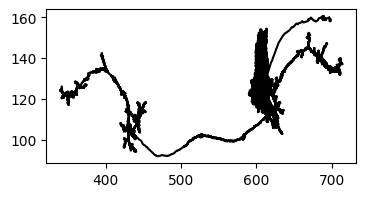

In [16]:
# Cell instance
cell = jx.read_swc(fileName, nseg=1)
cell.compute_xyz()  # Only needed for visualization.
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = cell.vis(ax=ax, col="k")

In [17]:
# load data
data = pd.read_csv("alpha2normalisedmean400ms (1).csv", header = None)
t_exp = data.iloc[0, 1:].values
v_exp = data.iloc[1, 1:].values
lower_bound = -100  # mV
upper_bound = 100   # mV

# Filter out the large values
filtered_indices = (v_exp >= lower_bound) & (v_exp <= upper_bound)
t_exp = t_exp[filtered_indices]
v_exp = v_exp[filtered_indices]
v_rest = -55.78571429
v_exp = [x * v_rest + v_rest for x in v_exp]

In [18]:
# Mechanism
cell.insert(Leak()) # can be specific to soma
cell.branch(0).set("Leak_gLeak", 9.0E-6)
cell.branch(0).set("axial_resistivity", 100)
cell.branch(0).set("capacitance", 0.7)
cell.nodes # soma is branch(0) by looking at radius, however length seems wrong

,comp_index,branch_index,cell_index,length,radius,axial_resistivity,capacitance,v,Leak,Leak_gLeak,Leak_eLeak
0,0,0,0,0.100000,2.310000,100.0,0.7,-70.0,True,0.000009,-70.0
1,1,1,0,4.330075,1.267500,5000.0,1.0,-70.0,True,0.000100,-70.0
2,2,2,0,5.167402,1.858000,5000.0,1.0,-70.0,True,0.000100,-70.0
3,3,3,0,0.123253,0.225500,5000.0,1.0,-70.0,True,0.000100,-70.0
4,4,4,0,0.437138,1.309000,5000.0,1.0,-70.0,True,0.000100,-70.0
...,...,...,...,...,...,...,...,...,...,...,...
30620,30620,30620,0,0.222402,0.191000,5000.0,1.0,-70.0,True,0.000100,-70.0
30621,30621,30621,0,0.084843,0.138000,5000.0,1.0,-70.0,True,0.000100,-70.0
30622,30622,30622,0,0.232397,0.191500,5000.0,1.0,-70.0,True,0.000100,-70.0
30623,30623,30623,0,0.064360,0.050500,5000.0,1.0,-70.0,True,0.000100,-70.0


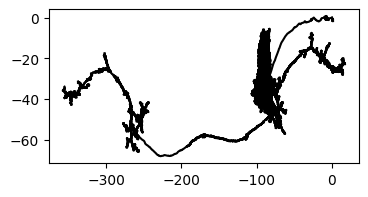

In [19]:
# Network to be trained
net = jx.Network([cell for _ in range(1)])
net.compute_xyz()
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = net.vis(ax=ax, detail="full", layers=[1])

In [20]:
net.delete_recordings()
net.cell(0).branch(0).loc(0.5).record()

Added 1 recordings. See `.recordings` for details.


In [21]:
# Make trainable
net.delete_trainables()
net.cell(0).branch(0).loc("all").make_trainable("Leak_gLeak")
net.cell(0).branch(0).loc("all").make_trainable("axial_resistivity")
net.cell(0).branch(0).loc("all").make_trainable("capacitance")


Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 1. Total number of trainable parameters: 3


In [22]:
t_max = 460
dt = 0.025

levels = 1
time_points = t_max // dt + 2
checkpoints = [int(np.ceil(time_points**(1/levels))) for _ in range(levels)]

In [ ]:
params = net.get_parameters()
s = jx.integrate(net, params=params, t_max=460)

In [32]:
transform = jx.ParamTransform(
    lowers={
        "Leak_gLeak": 1e-6,
        "axial_resistivity": 30,
        "capacitance": 0.6,
    },
    uppers={
        "Leak_gLeak": 1.2e-4,
        "axial_resistivity": 400,
        "capacitance": 2.6,
    }, 
)

In [31]:
def simulate(params):
    amp = [0] * 30 + [-0.01] * 400 + [0] * 30
    currents = jx.datapoint_to_step_currents(i_delay=30, i_dur=400, i_amp= amp, delta_t=0.025, t_max=460)
    plt.figure(figsize=(10, 5))

    plt.plot(amp, marker='o', linestyle='-', color='b')

    data_stimuli = None
    data_stimuli = net.cell(0).branch(0).loc(0.5).data_stimulate(currents[0], data_stimuli=data_stimuli)

    return jx.integrate(net, params=params, data_stimuli=data_stimuli)

batched_simulate = vmap(simulate, in_axes=(None, 0))

0
0


In [ ]:
def loss(opt_params, labels):
    transform.forward(opt_params)

    traces = batched_simulate(params)  # Shape `(batchsize, num_recordings, timepoints)`.
    prediction = jnp.mean(traces[:, 2], axis=0)
    losses = jnp.abs(prediction - labels)  # Mean absolute error loss.
    return jnp.mean(losses)  # Average across the batch.

In [ ]:
inputs = [1]

In [ ]:
jitted_grad = jit(value_and_grad(loss, argnums=0))
value, gradient = jitted_grad(params, v_exp)

In [ ]:
opt_params = transform.inverse(params)
optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(opt_params)

In [ ]:
batch_size = 1
tf.random.set_seed(1)
dataloader = Dataset.from_tensor_slices((v_exp))

In [ ]:
for epoch in range(50):
    epoch_loss = 0.0
    for batch_ind, batch in enumerate(dataloader):
        current_batch = batch[0].numpy()
        label_batch = batch[1].numpy()
        loss_val, gradient = jitted_grad(opt_params, current_batch, label_batch)
        updates, opt_state = optimizer.update(gradient, opt_state)
        opt_params = optax.apply_updates(opt_params, updates)
        epoch_loss += loss_val
    
    print(f"epoch {epoch}, loss {epoch_loss}")
    
final_params = transform.forward(opt_params)